In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Flatten, Dense, BatchNormalization,Conv1D, MaxPooling1D
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

2024-04-25 22:02:28.216067: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 22:02:28.374490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 22:02:28.374543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 22:02:28.394298: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 22:02:28.437648: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def getPreprocessedData():
    
    #Concatenate positive and negative samples
    trainFull = pd.read_csv("Data/trainFull.csv", index_col = 0)
    testFull = pd.read_csv("Data/testFull.csv", index_col = 0)
    
    #Randomize samples
    trainFull = trainFull.sample(len(trainFull))
    testFull = testFull.sample(len(testFull))

    #Randomize samples
    trainFull = trainFull.sample(len(trainFull))
    testFull = testFull.sample(len(testFull))

    #Reduce features and extract labels
    trainX = trainFull.iloc[:,:-1]
    trainY = trainFull.iloc[:,-1]
    testX = testFull.iloc[:,:-1]
    testY = testFull.iloc[:,-1]

    #Reshape data to 3D for CNN
    trainX = trainX.to_numpy()[..., None]
    trainY = trainY.to_numpy()[..., None]
    testX = testX.to_numpy()[..., None]
    testY = testY.to_numpy()[..., None]

    return trainX, trainY, testX, testY

In [3]:
trainX, trainY, testX, testY = getPreprocessedData()

In [8]:
def newModel(numConvFilters = 242, dropout = .215, numDenseNodes = 190):
    #Create new sequential model
    model = Sequential()

    #Add 1D Convolutional layers
    model.add(BatchNormalization())
    model.add((Conv1D(filters=32, kernel_size=3, activation='relu')))
    model.add((Conv1D(filters=numConvFilters, kernel_size=3, activation='relu')))
    #Add Max Pooling layer
    model.add((MaxPooling1D(pool_size=2)))
    #Apply dropout
    model.add(Dropout(dropout))
    #Flatten model
    model.add(Flatten())
    #Add fully connected dense layer
    model.add(Dense(numDenseNodes, activation='sigmoid'))
    #Add output node
    model.add(Dense(1, activation='sigmoid'))
    
    #Define optimizer
    
    adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #Compile model
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve='PR'),                                                                                         tf.keras.metrics.PrecisionAtRecall(0.8)])
    return model

In [9]:
model = newModel()
model.fit(trainX, trainY, epochs = 100, batch_size=20, verbose = 1)

Epoch 1/100


2024-04-25 22:04:55.494925: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


758/758 [==============================] - 8s 5ms/step - loss: 0.6809 - auc: 0.5658 - precision_at_recall: 0.5407
Epoch 2/100
758/758 [==============================] - 3s 4ms/step - loss: 0.6588 - auc: 0.6239 - precision_at_recall: 0.5629
Epoch 3/100
758/758 [==============================] - 3s 4ms/step - loss: 0.6458 - auc: 0.6471 - precision_at_recall: 0.5800
Epoch 4/100
758/758 [==============================] - 3s 4ms/step - loss: 0.6385 - auc: 0.6616 - precision_at_recall: 0.5884
Epoch 5/100
758/758 [==============================] - 3s 4ms/step - loss: 0.6370 - auc: 0.6656 - precision_at_recall: 0.5872
Epoch 6/100
758/758 [==============================] - 3s 4ms/step - loss: 0.6350 - auc: 0.6647 - precision_at_recall: 0.5949
Epoch 7/100
758/758 [==============================] - 3s 4ms/step - loss: 0.6265 - auc: 0.6776 - precision_at_recall: 0.6014
Epoch 8/100
758/758 [==============================] - 3s 4ms/step - loss: 0.6260 - auc: 0.6832 - precision_at_recall: 0.6071
Epoc

In [10]:
#create confusion Matrix
def confusionMatrix(model, testX, testY):
    pred = model.predict(testX)
    predy = []
    for i in range(0,len(pred)):
        if pred[i] >= .5:
            predy.append(1)
        else:
            predy.append(0)
        
    print(confusion_matrix(testY,predy))
    
#Calculates our model metrics
def modelMetrics(testX, testY, model):
    y_scores = model.predict(testX)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    rec80 = np.max(recall[precision >= .8])
    print("Recall at 80% Precision: " +str(rec80))
    aucPR = auc(recall, precision)
    print("PR-AUC: " + str(aucPR))
    
    return rec80, aucPR, 

#plots a PR curve
def PRplot(testX, testY, model):
    y_scores = model.predict(testX)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    plt.plot(recall, precision)
    plt.title("PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

119/119 [==============================] - 1s 5ms/step
Recall at 80% Precision: 0.8738786279683377
PR-AUC: 0.9145071069334998
119/119 [==============================] - 0s 2ms/step
[[1576  319]
 [ 341 1554]]
119/119 [==============================] - 0s 2ms/step


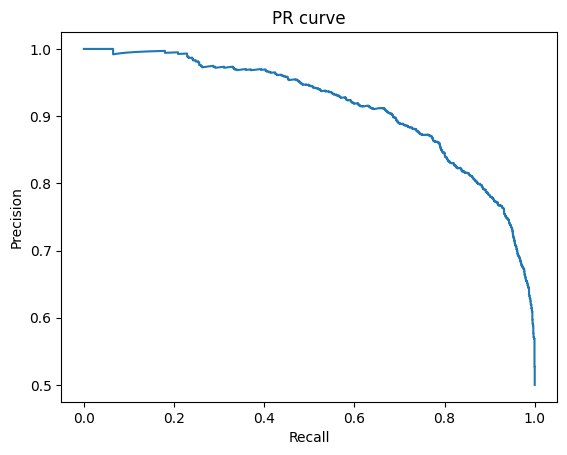

In [11]:
modelMetrics(testX, testY, model)
confusionMatrix(model, testX, testY)
PRplot(testX, testY, model)